1. Make sure you have access to the "Azavea R&D" AWS account
2. Clone this notebook: `File > Save a copy in Drive`
3. Enable GPU: `Runtime > Change runtime type > Hardware Accelerator > T4 GPU`

## Setup

Install Raster Vision

In [ ]:
!git clone --depth=1 https://github.com/AdeelH/raster-vision.git && \
  cd raster-vision && \
  git fetch https://github.com/AdeelH/raster-vision.git qe && \
  git checkout FETCH_HEAD && \
  cd -

In [ ]:
%pip install -q raster-vision/rastervision_pipeline;
%pip install -q raster-vision/rastervision_aws_s3;
%pip install -q raster-vision/rastervision_core;
%pip install -q raster-vision/rastervision_pytorch_learner;

Install other dependencies:

In [ ]:
%pip install -q open_clip_torch

---

!!! **Restart kernel here** !!!

---

Set AWS credentials:

In [ ]:
%%capture
%env AWS_REQUEST_PAYER=requester
%env AWS_ACCESS_KEY_ID=
%env AWS_SECRET_ACCESS_KEY=
%env AWS_SESSION_TOKEN=

---

In [ ]:
from rastervision.core.box import Box
from rastervision.core.data import RasterioSource

from tqdm.auto import tqdm
import numpy as np
import torch
import geopandas as gpd
from matplotlib import pyplot as plt
import seaborn as sns
sns.reset_defaults()

DEVICE = 'cuda'

---

## Load embeddings

In [ ]:
!aws s3 cp s3://raster-vision-ahassan/naip/skyscript_naip_MA_400_400.pt .
# !aws s3 cp s3://raster-vision-ahassan/naip/skyscript_naip_MA_800_800.pt .
# !aws s3 cp s3://raster-vision-ahassan/naip/skyscript_naip_MA_1600_1600.pt .

download: s3://raster-vision-ahassan/naip/skyscript_naip_MA_400_400.pt to ./skyscript_naip_MA_400_400.pt


In [ ]:
embs_400 = torch.load('skyscript_naip_MA_400_400.pt')
# embs_800 = torch.load('skyscript_naip_MA_800_800.pt')
# embs_1600 = torch.load('skyscript_naip_MA_1600_1600.pt')
embs_400.shape, #embs_800.shape, #embs_1600.shape

(torch.Size([563379, 768]),)

---

## Load chip windows

In [ ]:
!aws s3 cp s3://raster-vision-ahassan/naip/naip_MA_400_400_w_uris.json .
# !aws s3 cp s3://raster-vision-ahassan/naip/naip_MA_800_800_w_uris.json .
# !aws s3 cp s3://raster-vision-ahassan/naip/naip_MA_1600_1600_w_uris.json .

download: s3://raster-vision-ahassan/naip/naip_MA_400_400_w_uris.json to ./naip_MA_400_400_w_uris.json


In [ ]:
windows_df_400 = gpd.read_file('naip_MA_400_400_w_uris.json')
# windows_df_800 = gpd.read_file('naip_MA_800_800_w_uris.json')
# windows_df_1600 = gpd.read_file('naip_MA_1600_1600_w_uris.json')

---

## Init `RasterSource`s

In [ ]:
uris = set(windows_df_400.uri)
uri_to_rs = {
    uri: RasterioSource(uri, channel_order=[0, 1, 2], allow_streaming=True)
    for uri in tqdm(uris, desc='Initializing RasterSources')
}

Initializing RasterSources:   0%|          | 0/742 [00:00<?, ?it/s]

---

## Load model

Download model (~5 GB):

In [ ]:
!aws s3 cp s3://raster-vision-ahassan/qe/SkyCLIP_ViT_L14_top50pct/epoch_20.pt SkyCLIP.pt

download: s3://raster-vision-ahassan/qe/SkyCLIP_ViT_L14_top50pct/epoch_20.pt to ./SkyCLIP.pt


Init model and tokenizer:

In [ ]:
import open_clip

model_name = 'ViT-L-14'
model, _, preprocess = open_clip.create_model_and_transforms(model_name)
tokenizer = open_clip.get_tokenizer(model_name)

Load model weights:

In [ ]:
ckpt_path = 'SkyCLIP.pt'
ckpt = torch.load(ckpt_path, map_location=DEVICE)['state_dict']
ckpt = {k[len('module.'):]:v for k, v in ckpt.items()}
message = model.load_state_dict(ckpt)
model = model.cuda().eval()

---

## Search

In [ ]:
def get_chip_scores(text_queries, embs):
    assert len(text_queries) == 1
    text = tokenizer(text_queries)
    with torch.inference_mode():
        text_features = model.encode_text(text.to(DEVICE))
        text_features /= text_features.norm(dim=-1, keepdim=True)
        text_features = text_features.cpu()
        chip_scores = torch.cosine_similarity(text_features, embs)
    return chip_scores

def emb_idx_to_chip(i, windows_df, out_shape=(400, 400)):
    i = int(i)
    uri = windows_df.uri[i]
    window_geom = windows_df.geometry[i]
    window = Box.from_shapely(window_geom)
    rs = uri_to_rs[uri]
    chip = rs.get_chip_by_map_window(window, out_shape=out_shape)
    return chip

def show_top_chips(chip_scores, windows_df, top_inds=None, nrows=5, ncols=5, figsize=(12, 12), w_pad=-2.5, h_pad=-2.5):
    plt.close('all')
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
    fig.tight_layout(w_pad=w_pad, h_pad=h_pad)
    if top_inds is None:
        top_inds = torch.topk(chip_scores, axs.size).indices
    for ax, i in zip(tqdm(axs.flat), top_inds):
        chip = emb_idx_to_chip(i, windows_df)
        ax.imshow(chip)
    for ax in axs.flat:
        ax.axis('off')
    plt.show()

  0%|          | 0/8 [00:00<?, ?it/s]

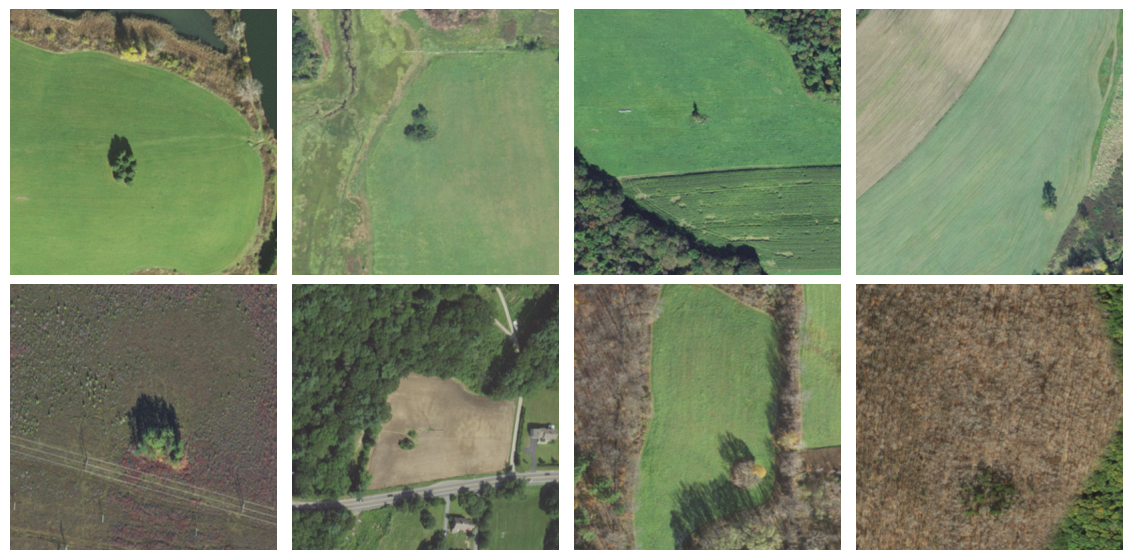

In [ ]:
text_queries = [
    # 'house with swimming pool',
    'a single tree in an empty field',
    # 'a large solar farm',
    # 'a long bridge over a large body of water',
]
chip_scores_400 = get_chip_scores(text_queries, embs_400)
show_top_chips(chip_scores_400, windows_df_400, nrows=2, ncols=4, figsize=(12, 6), w_pad=-(12/4), h_pad=-(6/4))
# chip_scores_800 = get_chip_scores(text_queries, embs_800)
# show_top_chips(chip_scores_800, windows_df_800, nrows=2, ncols=4, figsize=(12, 6), w_pad=-(12/4), h_pad=-(6/4))
# chip_scores_1600 = get_chip_scores(text_queries, embs_1600)
# show_top_chips(chip_scores_1600, windows_df_1600, nrows=2, ncols=4, figsize=(12, 6), w_pad=-(12/4), h_pad=-(6/4))

---

## Visualize matches on map

In [ ]:
!wget "https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json"

In [ ]:
us_df = gpd.read_file('us-states.json')
aoi_df = us_df[us_df.name == 'Massachusetts']

In [ ]:
top_inds = torch.topk(chip_scores_400, 100).indices
matched_windows_df = windows_df_400.iloc[top_inds]

In [ ]:
fig, ax = plt.subplots()
aoi_df.plot(ax=ax, ec='gray', fc='none')
intersection_df = matched_windows_df[matched_windows_df.within(aoi_df.unary_union)]
ax.scatter(intersection_df.centroid.x, intersection_df.centroid.y, s=16)
plt.show()